In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BICS_ABM import BICS_ABM, VaccineRule
import time
from joblib import Parallel, delayed
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, uniform, randint

import collections
import re

import datetime
import pickle
import dill

from scipy.signal import find_peaks

# Analysis for new idea: Vaccine timing and outbreak cycles

Begin by developing treatment combinations

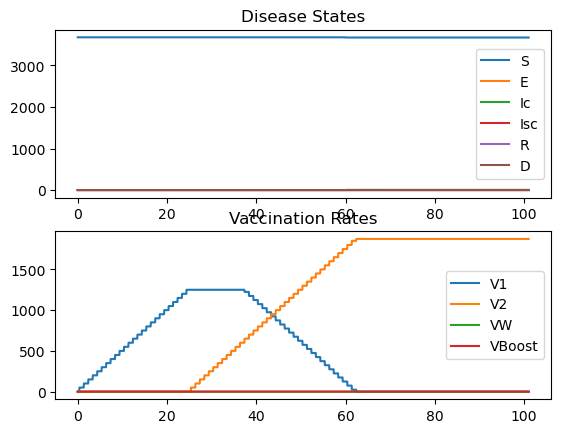

In [10]:
m = BICS_ABM(MAX_DAYS = 100, silent= True, T0 = 60)
m.plot_trajectory()

In [11]:
t_reinfection_vec = [180*24, 270*24, 360*24]
print(t_reinfection_vec)
t_booster_vec = np.cumsum([0, 31,28,31,30,31,30,31,31,30,31,30])
print(t_booster_vec)
ve_boost_vec = [.25, .50, .75]
print(ve_boost_vec)
ve_uptake_vec = ve_boost_vec

treatment_params = []
for r in t_reinfection_vec:
    for b in t_booster_vec:
        for ve in ve_boost_vec:
            for vu in ve_uptake_vec:
                treatment_params.append({'T_REINFECTION': r,
                                         'BOOSTER_DAY': b,
                                         'VEBOOST': ve,
                                         'VU': vu})
                


[4320, 6480, 8640]
[  0  31  59  90 120 151 181 212 243 273 304 334]
[0.25, 0.5, 0.75]


In [ ]:
len(treatment_params)

In [12]:
t = time.time()
import_cases = [1 if x%7 == 0 else 0 for x in range(365)]

def multi_fn(params):
    """ Wrapper function for multiprocessing
    
    """
    

    result = BICS_ABM( 
            N_HH = 1000,
            # SEED = 4949, 
            RHO = 1,
            ALPHA = 0.25,
            BETA0 = 0.05,
            BETA1 = 0.5,
            INDEX_CASES = 1,
            IMPORT_CASES_VEC = import_cases,
            # T0 = 60,
            ISOLATION_MULTIPLIER = 0.1, 
            N_VAX_DAILY = 100,
            T_REINFECTION = params['T_REINFECTION'],
            VEBOOST = params['VEBOOST'],
            vax_rules = [
                VaccineRule(general = True, hesitancy = params['VU']) #,
            ],
            MAX_DAYS=365*10,
            BOOSTER_DAY = params['BOOSTER_DAY'],
            silent = True)
    
    fname = "sims/2023_13_2/"
    for k, v in params.items():
        fname += k + "_" + str(v) + "__"
    fname += ".pickle"
    outfile = open(fname,'wb')
    pickle.dump(result, outfile)
    outfile.close()
    
    return 0 # result
    
    
result_vec = Parallel(n_jobs=8, verbose = 10)(delayed(multi_fn)(v) for v in treatment_params)
    
    
t = time.time() - t

print(len(treatment_params), "iterations took", t, "seconds")


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done   2 out of   7 | elapsed:  3.9min remaining:  9.7min
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:  3.9min remaining:  5.2min
[Parallel(n_jobs=8)]: Done   4 out of   7 | elapsed:  3.9min remaining:  2.9min


324 iterations took 235.2098686695099 seconds


[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:  3.9min remaining:  1.6min
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  3.9min finished
/Users/eroubenoff/BICS_ABM/BICS_ABM.py:78: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")
/Users/eroubenoff/BICS_ABM/BICS_ABM.py:78: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")
/Users/eroubenoff/BICS_ABM/BICS_ABM.py:78: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,1

In [14]:
import os
flist = os.listdir("sims/2023_13_2/")

sims = []
for i,f in enumerate(flist):
    
    try:
        p = open("sims/2023_13_2/" + f, "rb")
        sims.append(pickle.load(p))
        p.close()
        
    except:
        print("Failed at", i)

Failed at 51
Failed at 190


In [105]:
# Functions for analysis
from scipy.signal import find_peaks

def process_sim(sim):
    
    vu = np.mean(sim._pop[:,[i for i,x in enumerate(sim._colnames) if x == "vaccine_priority" ][0]] == 0)
    
    ret = {'T_REINFECTION': sim._params.T_REINFECTION,
              'BOOSTER_DAY': sim._params.BOOSTER_DAY,
              'VEBOOST': sim._params.VEBOOST,
              'VU': vu}
    N = sim.S[0] + sim.E[0]
    threshold = N * 0.01
    threshold= 2
    x = np.add.reduceat(sim.Cc, np.arange(0, len(sim.Cc), 24))
    peaks, properties = find_peaks(x, height=threshold, distance=30, width=1, rel_height=1)
    
    count = []
    for i in range(len(properties["left_ips"])):
        left_bound = round(properties["left_ips"][i])
        right_bound = round(properties["right_ips"][i])
        count.append(sum(x[left_bound:right_bound]))
            
    ret["num_outbreaks"] = len(peaks)
    ret["mean_time_bw_outbreaks"] = np.mean(np.diff(peaks))
    ret["avg_outbreak_size"] = np.mean(count)
    
    return ret
    

In [106]:
processed_sims = [process_sim(x) for x in simslist]

In [108]:
processed_sims = pd.DataFrame(processed_sims)

In [109]:
processed_sims

,T_REINFECTION,BOOSTER_DAY,VEBOOST,VU,num_outbreaks,mean_time_bw_outbreaks,avg_outbreak_size
0,4320,300,0.82,0.242143,41,88.100000,438.219512
1,8760,300,0.82,0.498885,27,135.230769,207.629630
2,17520,300,0.82,0.503452,16,213.600000,350.812500
3,8760,300,0.82,0.738915,21,171.500000,183.809524
4,17520,300,0.82,0.750206,20,177.263158,69.650000
...,...,...,...,...,...,...,...
95,4320,300,0.82,0.742449,47,77.326087,195.297872
96,8760,300,0.82,0.236591,27,135.576923,356.925926
97,4320,300,0.82,0.505824,36,100.828571,366.638889
98,8760,300,0.82,0.250137,27,136.153846,333.518519


Text(0.5, 0, 'Time until reinfection (days)')

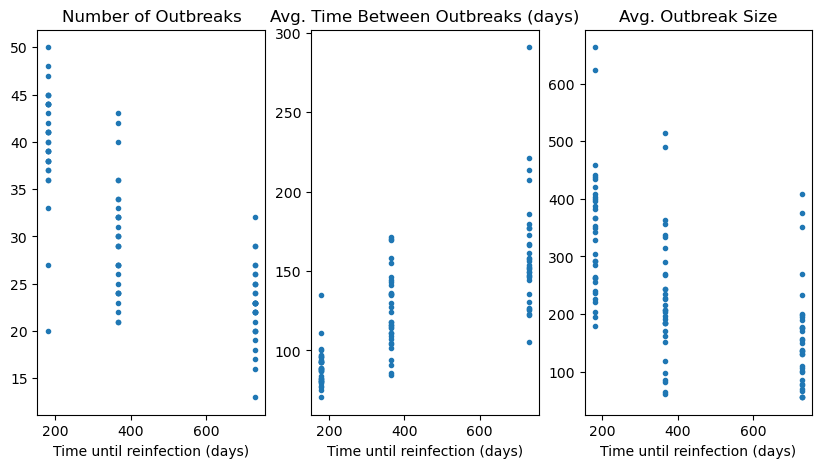

In [110]:
fig, ax = plt.subplots(ncols=3,figsize= (10,5))
ax[0].plot(processed_sims.T_REINFECTION/24, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Time until reinfection (days)")
ax[1].plot(processed_sims.T_REINFECTION/24, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Time until reinfection (days)")
ax[2].plot(processed_sims.T_REINFECTION/24, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Time until reinfection (days)")

Text(0.5, 0, 'Booster Day')

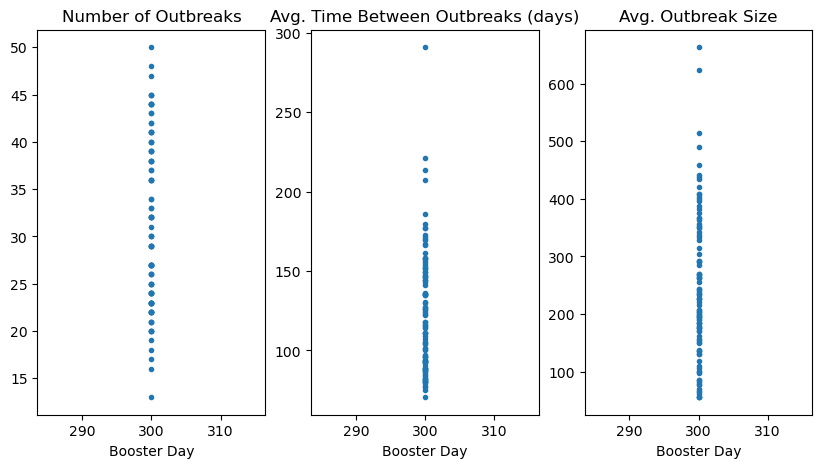

In [111]:
fig, ax = plt.subplots(ncols=3,figsize= (10,5))
ax[0].plot(processed_sims.BOOSTER_DAY, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Booster Day")
ax[1].plot(processed_sims.BOOSTER_DAY, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Booster Day")
ax[2].plot(processed_sims.BOOSTER_DAY, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Booster Day")

Text(0.5, 0, 'Booster Efficacy')

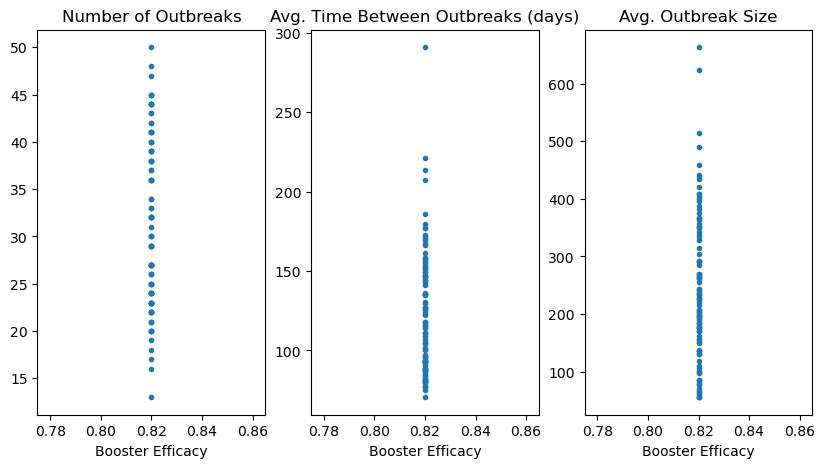

In [112]:
fig, ax = plt.subplots(ncols=3,figsize= (10,5))
ax[0].plot(processed_sims.VEBOOST, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Booster Efficacy")
ax[1].plot(processed_sims.VEBOOST, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Booster Efficacy")
ax[2].plot(processed_sims.VEBOOST, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Booster Efficacy")

Text(0.5, 0, 'Vaccine Uptake Rate')

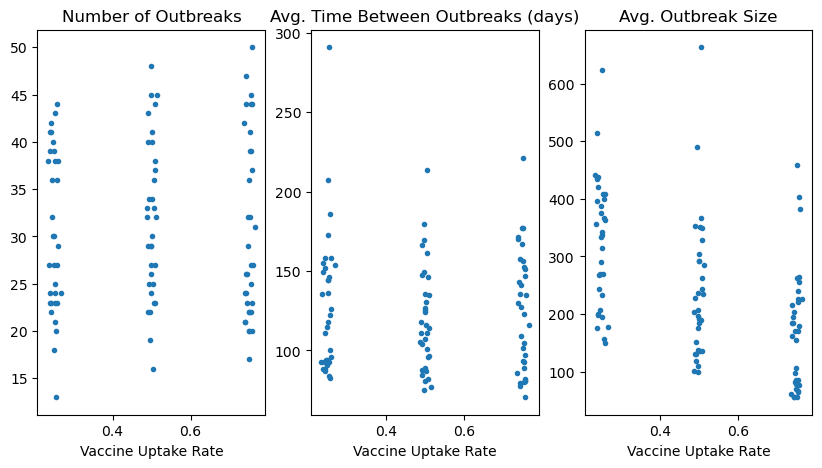

In [113]:
fig, ax = plt.subplots(ncols=3,figsize= (10,5))
ax[0].plot(processed_sims.VU, processed_sims.num_outbreaks, ".", )
ax[0].set_title("Number of Outbreaks")
ax[0].set_xlabel("Vaccine Uptake Rate")
ax[1].plot(processed_sims.VU, processed_sims.mean_time_bw_outbreaks, ".")
ax[1].set_title("Avg. Time Between Outbreaks (days)")
ax[1].set_xlabel("Vaccine Uptake Rate")
ax[2].plot(processed_sims.VU, processed_sims.avg_outbreak_size, ".")
ax[2].set_title("Avg. Outbreak Size")
ax[2].set_xlabel("Vaccine Uptake Rate")

(array([104.,  98.,  84., 123.,  96., 101.,  90., 115.,  86., 103.]),
 array([0.01025826, 0.01923193, 0.02820561, 0.03717929, 0.04615296,
        0.05512664, 0.06410031, 0.07307399, 0.08204767, 0.09102134,
        0.09999502]),
 <BarContainer object of 10 artists>)

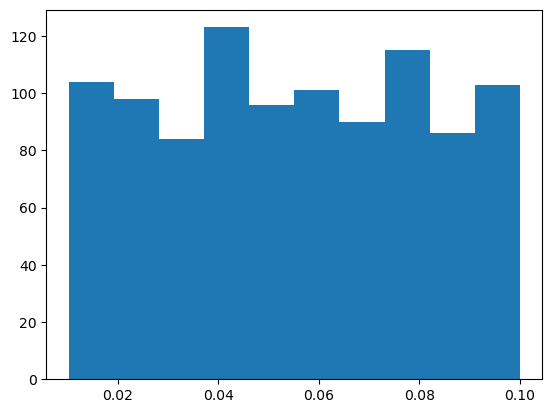

In [37]:
from scipy.stats import uniform
plt.hist(uniform.rvs(0.01, 0.09,1000))

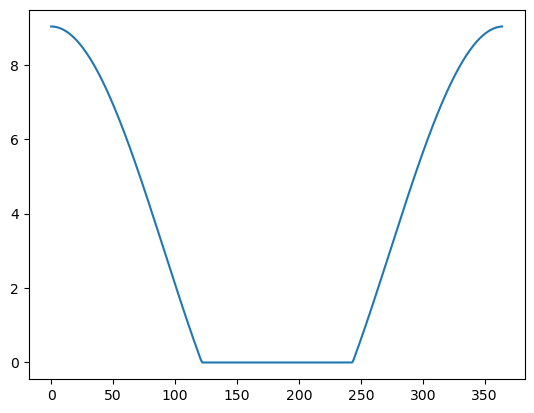

In [46]:
beta0 = 3.01
beta1 = 2
v = [max(0, beta0 * (1+beta1*np.cos((2*np.pi)/365*t))) for t in range(365)]
plt.plot(v)

In [49]:
from scipy.stats.qmc import LatinHypercube

x = LatinHypercube(d=2).random(n=100)

print(x)

[[0.57469756 0.47098587]
 [0.66646889 0.28327609]
 [0.11617621 0.95504633]
 [0.78638875 0.34795655]
 [0.97552949 0.18556965]
 [0.81876088 0.94872829]
 [0.69255364 0.6487213 ]
 [0.98715983 0.37953447]
 [0.21315191 0.06027193]
 [0.94864601 0.14286053]
 [0.64004008 0.66424323]
 [0.31320562 0.76179316]
 [0.72522467 0.93155219]
 [0.40431331 0.4290282 ]
 [0.08684487 0.08713138]
 [0.02040371 0.05472497]
 [0.46464171 0.43639612]
 [0.92447336 0.74681179]
 [0.83206502 0.12222014]
 [0.28594957 0.27306787]
 [0.06960556 0.69894841]
 [0.54813217 0.87960434]
 [0.53189748 0.36707379]
 [0.37564638 0.67263942]
 [0.50110935 0.85028054]
 [0.19316969 0.15468479]
 [0.75654525 0.62602868]
 [0.90305746 0.19190023]
 [0.52413542 0.00713628]
 [0.87645584 0.48718159]
 [0.27045423 0.72838617]
 [0.9978873  0.68851974]
 [0.38401967 0.11906194]
 [0.26363068 0.90930255]
 [0.01587249 0.07723327]
 [0.76686494 0.40394393]
 [0.4207564  0.81603822]
 [0.88201375 0.16143478]
 [0.91904454 0.25240785]
 [0.4115937  0.89288007]


In [98]:
dirname = "sims/2023_15_2/"
flist = [dirname + x for x in os.listdir(dirname) if '.pgz' in x]
print(flist)

['sims/2023_15_2/BETA0_0.01__BETA1_0.0__BOOSTER_DAY_300__T_REINFECTION_4320__SEED_8027953__.pgz', 'sims/2023_15_2/BETA0_0.01__BETA1_0.2__BOOSTER_DAY_300__T_REINFECTION_8760__SEED_5913104__.pgz', 'sims/2023_15_2/BETA0_0.02__BETA1_0.0__BOOSTER_DAY_300__T_REINFECTION_17520__SEED_1431042__.pgz', 'sims/2023_15_2/BETA0_0.01__BETA1_0.1__BOOSTER_DAY_300__T_REINFECTION_8760__SEED_7638560__.pgz', 'sims/2023_15_2/BETA0_0.01__BETA1_0.6000000000000001__BOOSTER_DAY_300__T_REINFECTION_17520__SEED_9488345__.pgz', 'sims/2023_15_2/BETA0_0.01__BETA1_0.5__BOOSTER_DAY_300__T_REINFECTION_17520__SEED_4279553__.pgz', 'sims/2023_15_2/BETA0_0.01__BETA1_0.4__BOOSTER_DAY_300__T_REINFECTION_8760__SEED_2760372__.pgz', 'sims/2023_15_2/BETA0_0.01__BETA1_0.9__BOOSTER_DAY_300__T_REINFECTION_17520__SEED_1130684__.pgz', 'sims/2023_15_2/BETA0_0.02__BETA1_0.1__BOOSTER_DAY_300__T_REINFECTION_4320__SEED_1608664__.pgz', 'sims/2023_15_2/BETA0_0.02__BETA1_0.0__BOOSTER_DAY_300__T_REINFECTION_17520__SEED_7469509__.pgz', 'sims/202

In [99]:
simslist = []
for f in flist:
    with gzip.open(f, 'rb') as f:
        simslist.append(pickle.load(f))

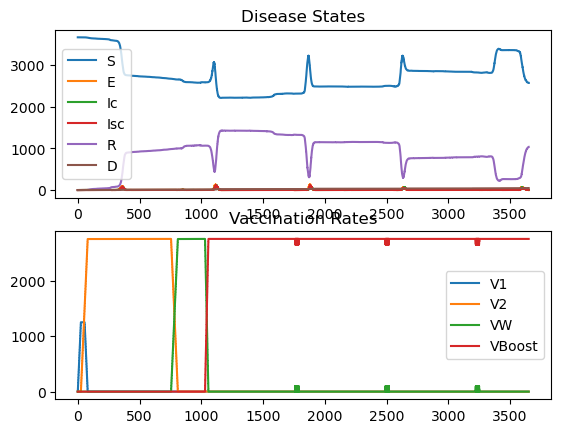

In [102]:
simslist[75].plot_trajectory()

In [96]:
min(sim.Isc)

0